<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> CC3104 - Aprendizaje por Refuerzo 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Agente de trading que aprenda a tomar decisiones de compra, venta o mantenimiento de un activo financiero dentro de un mercado simulado</strong></p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
      </ul>
    </td>
  </tr>
</table>

### Instalación de dependencias e importación de librerías

In [ ]:
#!pip install numpy pandas matplotlib jupyterlab
#!pip install --index-url https://download.pytorch.org/whl/cpu torch
#!pip install --index-url https://download.pytorch.org/whl/cu121 torch # cuda

In [ ]:
# Importar librerías y módulos
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PyTorch para Deep Q-Network
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass
from typing import Deque, Tuple, List

# Reproducibilidad
SEED = 2000
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Ajustes de gráficos
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

In [4]:
# Hiperparámetros del entorno y de Deep Q-Network

# Entorno
N_STEPS = 4000 # longitud de pasos en entrenamiento
TEST_STEPS = 1200 # longitud en test
WINDOW = 30 # tamaño de la ventana de observación
TRANS_COST = 0.001 # costo de transacción por cambiar de posición
INIT_CASH = 1_000.0 # efectivo inicial
UNIT_POSITION = 1 # tamaño unitario de posición
ALLOW_SHORT = True # permitir posición -1 (venta en corto)
VOL_SCALE = 0.20 # volatilidad anualizada para Gradient Boosting Models
DRIFT = 0.05 # drift anualizado para GBM

# DQN
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 128
REPLAY_SIZE = 50_000
MIN_REPLAY = 2_000 # pasos mínimos antes de entrenar
TARGET_SYNC = 1000 # frecuencia de sync a la target net
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY_STEPS = 30_000
TRAIN_STEPS = 50_000 # total de pasos de entrenamiento
DOUBLE_DQN = True # usar Double DQN

# Evaluación
RISK_FREE = 0.0 # se asume tasa libre de riesgo 0 para Sharpe simple

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

### Generación de precios para el entorno

In [ ]:
# Generación de precios y demás utilidades

def geometric_brownian_motion(
        # Genera una trayectoria GBM discreta:
        # S_{t+1} = S_t * exp((mu - 0.5 sigma^2) dt + sigma * sqrt(dt) * Z_t)
        # # Retorna arreglo de precios (longitud n_steps).
        n_steps: int,
        s0: float = 100.0,
        mu: float = DRIFT,
        sigma: float = VOL_SCALE,
        dt: float = 1/252) -> np.ndarray:
    
    prices = np.zeros(n_steps, dtype=np.float64)
    prices[0] = s0
    for t in range(1, n_steps):
        z = np.random.randn()
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * math.sqrt(dt) * z)
    return prices

def to_log_returns(prices: np.ndarray) -> np.ndarray: # Retornos logarítmicos r_t = log(S_t / S_{t-1})
    r = np.zeros_like(prices)
    r[1:] = np.diff(np.log(prices))
    return r

def sharpe_ratio(returns: np.ndarray, risk_free: float = RISK_FREE, eps: float = 1e-9) -> float:
    # Sharpe diario sobre retornos diarios (media - rf) / std.
    if returns.std() < eps:
        return 0.0
    return float((returns.mean() - risk_free) / (returns.std() + eps)) * math.sqrt(252)

def max_drawdown(equity: np.ndarray) -> float: # Máxima caída (drawdown) en porcentaje positivo
    peaks = np.maximum.accumulate(equity)
    drawdowns = 1.0 - (equity / np.maximum(peaks, 1e-9))
    return float(drawdowns.max())

def plot_equity(equity_dict: dict, title="Equity curves"): # Gráfico para curvas de equidad
    for label, eq in equity_dict.items():
        plt.plot(eq, label=label)
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Equity (value)")
    plt.legend()
    plt.show()

### Entorno de trading

In [6]:
# Entorno de trading uniactivo con acciones discretas {sell, hold, buy} -> posiciones {-1, 0, +1}.
# Recompensa = Δ(valor portafolio) neto de costos al cambiar de posición.
# Observación = [ventana de retornos recientes, posición_actual]

class TradingEnv:
    def __init__(self, prices: np.ndarray, window: int = WINDOW, trans_cost: float = TRANS_COST,
                 init_cash: float = INIT_CASH, allow_short: bool = True):
        self.prices = prices.astype(np.float64)
        self.returns = to_log_returns(self.prices)
        self.window = window
        self.trans_cost = trans_cost
        self.init_cash = init_cash
        self.allow_short = allow_short
        self.reset()

    def reset(self):
        self.t = self.window  # primer índice válido para ventana
        self.cash = float(self.init_cash)
        self.position = 0     # -1, 0, +1
        self.equity = [self.cash]
        self.last_price = float(self.prices[self.t-1])
        return self._get_obs()

    def _get_obs(self):
        # obs = [retornos_window, posición_norm]
        window_rets = self.returns[self.t - self.window : self.t]
        pos_norm = np.array([self.position], dtype=np.float32)  # ya está en [-1,0,1]
        obs = np.concatenate([window_rets.astype(np.float32), pos_norm], axis=0)
        return obs

    def step(self, action: int):
        # action in {0,1,2} -> {sell(-1), hold(0), buy(+1)}.
        # Cambiar de posición incurre en costo: trans_cost * precio * |delta_pos| * UNIT_POSITION
        # Recompensa = Δequity (cambio en valor de portafolio) = pnl de la posición + costos (negativos)

        assert action in (0, 1, 2)
        desired_pos = {-1: 0, 0: 1, 1: 2}[self.position]  # mapeo solo para claridad
        target_pos = {-1: 0, 0: 0, 1: 0}  # placeholder

        target = {-1: 0, 0: 0, 1: 0} # ignora

        if action == 0: # sell -> posición -1
            new_pos = -1 if self.allow_short else 0
        elif action == 1: # hold -> mantener
            new_pos = self.position
        else: # buy -> +1
            new_pos = 1

        price_t = float(self.prices[self.t])
        price_tm1 = float(self.prices[self.t - 1])
        ret_t = math.log(price_t / price_tm1 + 1e-12) # retorno log

        # PnL por tener la posición previa en [t-1, t]
        pnl = self.position * ret_t * self.cash  # aproximación: valoriza sobre cash
        # Alternativa más fiel: trackear cantidad de activos; aquí simplificamos para claridad.

        # Costo por cambiar de posición en caso de cambios.
        delta_pos = abs(new_pos - self.position)
        cost = delta_pos * self.trans_cost * price_t * UNIT_POSITION

        # Actualizamos estado financiero
        self.cash += pnl - cost
        self.position = new_pos
        self.equity.append(self.cash)

        # Recompensa = delta equity paso a paso (pnl - cost)
        reward = pnl - cost

        self.t += 1
        done = self.t >= len(self.prices)
        obs = self._get_obs() if not done else None
        info = {"pnl": pnl, "cost": cost, "price": price_t}
        return obs, float(reward), bool(done), info

### Crear datos de entrenamiento y prueba

Random steps: 200, reward mean=-1.329734, equity=734.05


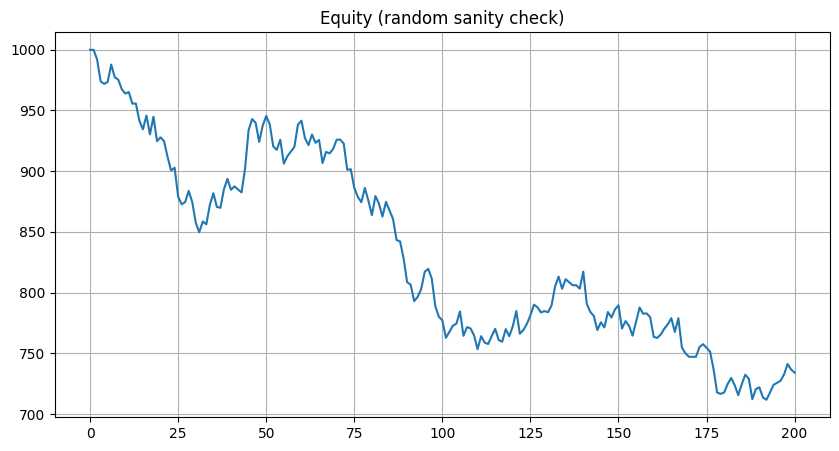

In [ ]:
# Datos de entrenamiento
train_prices = geometric_brownian_motion(N_STEPS, s0=100.0, mu=DRIFT, sigma=VOL_SCALE)
env_train = TradingEnv(train_prices, window=WINDOW, trans_cost=TRANS_COST, init_cash=INIT_CASH, allow_short=ALLOW_SHORT)

# Datos de test (con una trayectoria distinta)
test_prices = geometric_brownian_motion(TEST_STEPS, s0=train_prices[-1], mu=DRIFT, sigma=VOL_SCALE)
env_test = TradingEnv(test_prices, window=WINDOW, trans_cost=TRANS_COST, init_cash=INIT_CASH, allow_short=ALLOW_SHORT)

# Sanity check con política aleatoria
obs = env_train.reset()
rewards = []
for _ in range(200):
    a = np.random.randint(0, 3)
    obs, r, done, info = env_train.step(a)
    rewards.append(r)
    if done:
        break

print(f"Random steps: {len(rewards)}, reward mean={np.mean(rewards):.6f}, equity={env_train.equity[-1]:.2f}")
plt.plot(env_train.equity); plt.title("Equity (random sanity check)"); plt.show()

### Replay buffer

In [14]:
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, capacity: int = REPLAY_SIZE):
        self.buffer: Deque[Transition] = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Transition:
        batch = random.sample(self.buffer, batch_size)
        states = np.stack([b.state for b in batch], axis=0)
        actions = np.array([b.action for b in batch], dtype=np.int64)
        rewards = np.array([b.reward for b in batch], dtype=np.float32)
        next_states = np.stack([b.next_state for b in batch], axis=0)
        dones = np.array([b.done for b in batch], dtype=np.float32)
        return Transition(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

### Q-Network y agente Deep Q-Network con DDQN

In [15]:
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, n_actions: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, obs_dim: int, n_actions: int = 3, gamma: float = GAMMA, lr: float = LR,
                 double_dqn: bool = DOUBLE_DQN):
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.double_dqn = double_dqn

        self.q = QNetwork(obs_dim, n_actions).to(DEVICE)
        self.q_target = QNetwork(obs_dim, n_actions).to(DEVICE)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()

        self.optim = optim.Adam(self.q.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.eps = EPS_START

    def act(self, obs: np.ndarray) -> int:
        if np.random.rand() < self.eps:
            return np.random.randint(0, self.n_actions)
        with torch.no_grad():
            x = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            qvals = self.q(x)
            return int(torch.argmax(qvals, dim=1).item())

    def update_eps(self, step: int):
        # decaimiento lineal hasta EPS_END
        frac = min(1.0, step / EPS_DECAY_STEPS)
        self.eps = EPS_START + frac * (EPS_END - EPS_START)

    @torch.no_grad()
    def _q_next_targets(self, next_states: torch.Tensor) -> torch.Tensor:
        # Double DQN: seleccionar acción con Q online, evaluar con Q target
        if self.double_dqn:
            next_q_online = self.q(next_states) # [B, A]
            next_actions = torch.argmax(next_q_online, dim=1) # [B]
            next_q_target = self.q_target(next_states) # [B, A]
            next_best = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_q_target = self.q_target(next_states) # [B, A]
            next_best, _ = torch.max(next_q_target, dim=1)
        return next_best

    def train_step(self, batch: Transition):
        states = torch.tensor(batch.state, dtype=torch.float32, device=DEVICE)
        actions = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=DEVICE)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=DEVICE)

        qvals = self.q(states).gather(1, actions).squeeze(1) # Q(s,a)

        with torch.no_grad():
            next_best = self._q_next_targets(next_states)
            targets = rewards + (1.0 - dones) * self.gamma * next_best

        loss = self.loss_fn(qvals, targets)
        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), 1.0)
        self.optim.step()

        return float(loss.item())

    def sync_target(self):
        self.q_target.load_state_dict(self.q.state_dict())


### Entrenamiento

Step   5000 | eps=0.842 | meanReward(last5k)=0.290852 | equity=1752.22
Step  10000 | eps=0.683 | meanReward(last5k)=-0.293487 | equity=439.01
Step  15000 | eps=0.525 | meanReward(last5k)=0.513381 | equity=3663.09
Step  20000 | eps=0.367 | meanReward(last5k)=0.047789 | equity=1099.76
Step  25000 | eps=0.208 | meanReward(last5k)=6.601212 | equity=1353.78
Step  30000 | eps=0.050 | meanReward(last5k)=0.615402 | equity=2796.35
Step  35000 | eps=0.050 | meanReward(last5k)=1.713812 | equity=1414.68
Step  40000 | eps=0.050 | meanReward(last5k)=1.153770 | equity=1271.48
Step  45000 | eps=0.050 | meanReward(last5k)=2.609402 | equity=1427.13
Step  50000 | eps=0.050 | meanReward(last5k)=2.976170 | equity=1725.16


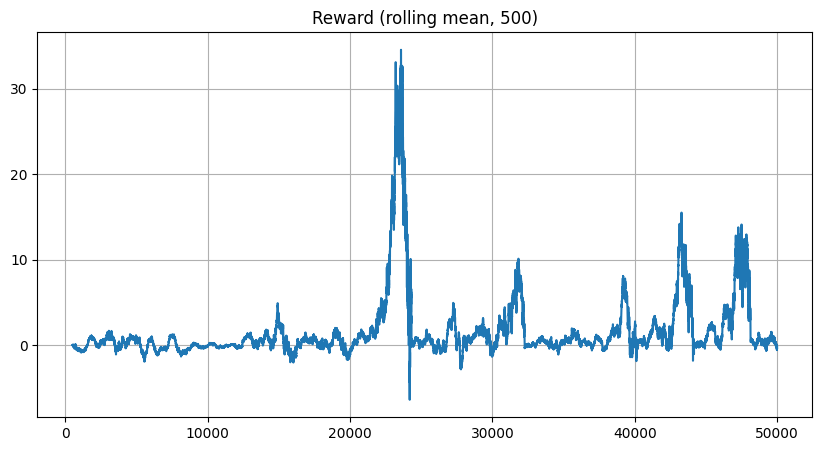

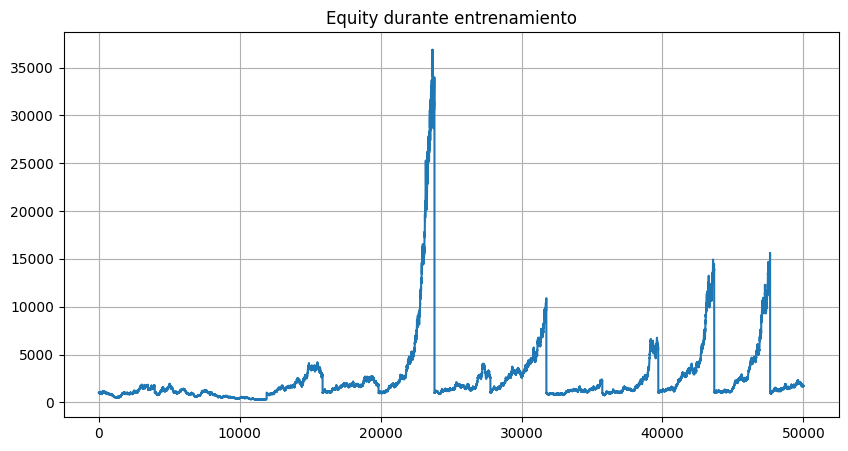

In [16]:
buffer = ReplayBuffer(REPLAY_SIZE)
agent = DQNAgent(obs_dim=WINDOW + 1, n_actions=3, gamma=GAMMA, lr=LR, double_dqn=DOUBLE_DQN)

obs = env_train.reset()
train_rewards = []
train_losses = []
equity_track = []

for step in range(1, TRAIN_STEPS + 1):
    agent.update_eps(step)
    action = agent.act(obs)
    next_obs, reward, done, info = env_train.step(action)

    # Guardar en replay
    if not done:
        buffer.push(obs, action, reward, next_obs, 0.0)
        obs = next_obs
    else:
        # Terminal
        buffer.push(obs, action, reward, np.zeros_like(obs, dtype=np.float32), 1.0)
        obs = env_train.reset()

    train_rewards.append(reward)
    equity_track.append(env_train.equity[-1])

    # Entrenar cuando haya experiencias suficientes
    if len(buffer) >= MIN_REPLAY:
        batch = buffer.sample(BATCH_SIZE)
        loss = agent.train_step(batch)
        train_losses.append(loss)

    # Sincronizar target
    if step % TARGET_SYNC == 0:
        agent.sync_target()

    # Logging ligero
    if step % 5000 == 0:
        mean_r = np.mean(train_rewards[-5000:])
        print(f"Step {step:6d} | eps={agent.eps:.3f} | meanReward(last5k)={mean_r:.6f} | equity={equity_track[-1]:.2f}")

# Curvas de entrenamiento
plt.plot(pd.Series(train_rewards).rolling(500).mean()); plt.title("Reward (rolling mean, 500)"); plt.show()
plt.plot(equity_track); plt.title("Equity durante entrenamiento"); plt.show()


### Evaluación en el conjunto de prueba mediante greedy policy

TEST | Total Return=-13.59% | Sharpe=-0.159 | MaxDD=46.10%


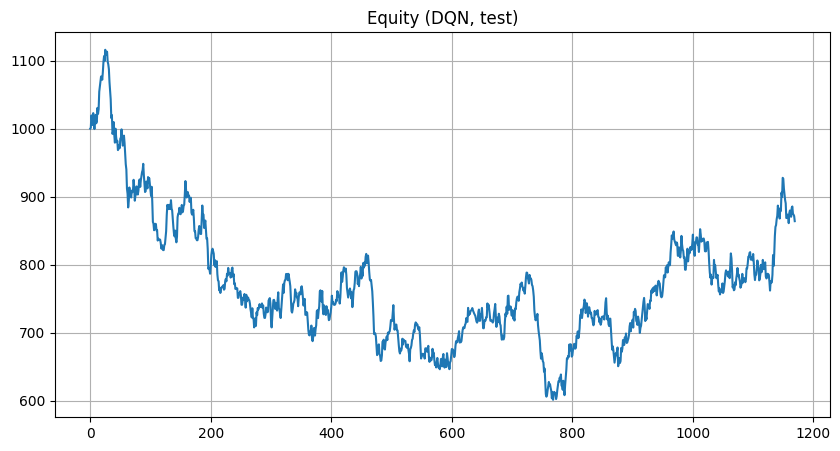

In [ ]:
def run_episode(env: TradingEnv, policy_fn, render: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    obs = env.reset()
    rewards, equity = [], []
    while True:
        a = policy_fn(obs)
        obs, r, done, info = env.step(a)
        rewards.append(r)
        equity.append(env.equity[-1])
        if done:
            break
    return np.array(rewards, dtype=np.float32), np.array(equity, dtype=np.float64)

# Política greedy sin exploración
def greedy_policy(obs):
    with torch.no_grad():
        x = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        qvals = agent.q(x)
        return int(torch.argmax(qvals, dim=1).item())

test_rewards, test_equity = run_episode(env_test, greedy_policy)
test_returns = np.diff(np.log(test_equity + 1e-9), prepend=np.log(test_equity[0]+1e-9))  # aprox

sr = sharpe_ratio(test_returns)
mdd = max_drawdown(test_equity)
ret_total = (test_equity[-1] / test_equity[0]) - 1.0

print(f"TEST | Total Return={ret_total:.2%} | Sharpe={sr:.3f} | MaxDD={mdd:.2%}")
plt.plot(test_equity); plt.title("Equity (DQN, test)"); plt.show()